# Objective

Tune parameters for LocalMaxPeakFinder (LMP) using RCA image round 0 channel 1.

In [1]:
import pandas as pd
import numpy as np
import os, warnings
from instapipeline import QuantiusAnnotation, SpotAnnotationAnalysis, param

from starfish import data, FieldOfView
from starfish.image import Filter
from starfish.spots import DetectSpots
from starfish.types import Axes

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from skimage.io import imread

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/napari/__init__.py:27: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.12.2. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


In [2]:
test_img_filename = 'ISS_rnd0_ch1_z0'

round_ind = 0
channel_ind = 1

origins = ['expert', 'consensus']
correctness_threshold = 10
stringencies = range(21)

In [3]:
use_test_data = os.getenv("USE_TEST_DATA") is not None
experiment = data.ISS(use_test_data=use_test_data)
fov = experiment.fov()
imgs = fov.get_image(FieldOfView.PRIMARY_IMAGES)

100%|██████████| 16/16 [00:00<00:00, 27.48it/s]


In [4]:
# filter raw data
masking_radius = 15
filt = Filter.WhiteTophat(masking_radius, is_volume=False)
filtered_imgs = filt.run(imgs, verbose=True, in_place=False)

16it [00:12,  1.58s/it]


In [5]:
if not os.path.exists('./blobs_lmp/'):
    os.mkdir('./blobs_lmp/')

In [42]:
for stringency in stringencies:

    print(stringency)

    test_img_path = './test_images_filtered/images/%s.png' % test_img_filename
    im = imread(test_img_path, as_gray=True)
    img_height = len(im)

    # slice the ImageStack
    sel={Axes.ROUND: round_ind, Axes.CH: channel_ind, Axes.ZPLANE: 0}
    single_plane_filtered = filtered_imgs.sel(sel)

    lmp = DetectSpots.LocalMaxPeakFinder(
        min_distance=6,
        stringency=stringency,
        min_obj_area=6,
        max_obj_area=600,
    )

    new_stack = single_plane_filtered.from_numpy(single_plane_filtered.xarray.values) 
    intensities = lmp.run(new_stack)
    spots = intensities[:, 0, 0].where(intensities[:, 0, 0] != 0, drop=True)
    x_vals = spots.x.values
    y_vals = spots.y.values

    blobs = []
    for x, y in zip(x_vals, y_vals):
        blobs.append([x, y])
    blobs = np.asarray(blobs)

    path = './blobs_lmp/%s_%s.csv' % (test_img_filename, stringency)
    np.savetxt(path, blobs, delimiter=",")


In [29]:
precision_recall = []
expert_path = './test_images_filtered/coords/%s.csv' % test_img_filename
consensus_path = './consensus/%s/total.csv' % test_img_filename

for stringency in stringencies:
    print(stringency)
    for origin in origins:

        ref_path = expert_path if origin=='expert' else consensus_path
        ref_coords = np.asarray(pd.read_csv(ref_path))  

        print(ref_path)

        # calc precision and recall
        precision, recall = param.get_precision_recall(test_coords=blobs, ref_coords=ref_coords, correctness_threshold=correctness_threshold)
        precision_recall.append((precision, recall))

        blobs = np.asarray(pd.read_csv('./blobs_lmp_4/%s_%s.csv' % (test_img_filename, stringency), header=None))

        print(precision, recall)
#         ####################
#         plt.figure(figsize=(10,10))
#         for x, y in blobs:
#             plt.scatter([x], [y], edgecolor='cyan', facecolor='None')
#         plt.imshow(im, cmap='gray')
#         for x, y in ref_coords:
#             plt.scatter([x], [y], edgecolor='yellow', facecolor='None')
#         plt.title('Stringency = %s. Precision = %s, Recall = %s based on %s annotations' % (stringency, round(precision, 2), round(recall, 2), origin))
#         plt.show()
#         ###################
np.savetxt('./blobs_lmp_0_1/precision_recall.csv' % test_img_filename, precision_recall, delimiter=",")

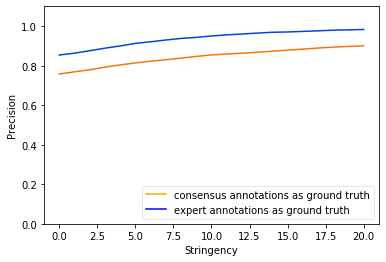

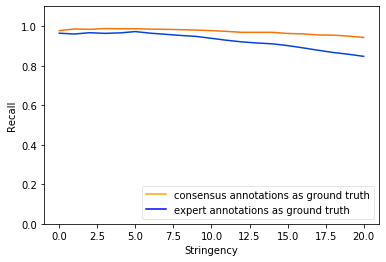

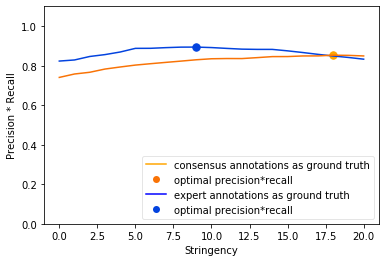

In [29]:
precision_recall = np.asarray(pd.read_csv('./blobs_lmp_0_1/precision_recall.csv', header=None))
expert_precision_recall, consensus_precision_recall = [], []
for ind, pr in enumerate(precision_recall):
    p, r = pr
    if ind % 2 == 0:
        expert_precision_recall.append([p,r])
    else:
        consensus_precision_recall.append([p,r])
        
expert_precision = [x[0] for x in expert_precision_recall]
consensus_precision = [x[0] for x in consensus_precision_recall]
plt.figure()
plt.plot(stringencies, expert_precision, c='xkcd:blue')
plt.plot(stringencies, consensus_precision, c='xkcd:orange')

leg_elem_1 = Line2D([0], [0], marker='None', color='orange', label='consensus annotations as ground truth')
leg_elem_2 = Line2D([0], [0], marker='None', color='b', label='expert annotations as ground truth')
handle_list = [leg_elem_1, leg_elem_2]
plt.legend(handles=handle_list, loc='lower right', frameon=1, prop={'size':10}, framealpha=0.5)

plt.xlabel('Stringency')
plt.ylabel('Precision')
plt.ylim(0, 1.1)

filename = "precision_v_stringency.pdf"
plt.savefig(filename, transparent=True, bbox_inches="tight")

plt.show()

######################

expert_recall = [x[1] for x in expert_precision_recall]
consensus_recall = [x[1] for x in consensus_precision_recall]
plt.figure()
plt.plot(stringencies, expert_recall, c='xkcd:blue')
plt.plot(stringencies, consensus_recall, c='xkcd:orange')

leg_elem_1 = Line2D([0], [0], marker='None', color='orange', label='consensus annotations as ground truth')
leg_elem_2 = Line2D([0], [0], marker='None', color='b', label='expert annotations as ground truth')
handle_list = [leg_elem_1, leg_elem_2]
plt.legend(handles=handle_list, loc='lower right', frameon=1, prop={'size':10}, framealpha=0.5)

plt.xlabel('Stringency')
plt.ylabel('Recall')
plt.ylim(0, 1.1)

filename = "recall_v_stringency.pdf"
plt.savefig(filename, transparent=True, bbox_inches="tight")

plt.show()

######################

expert_precision_x_recall = [x * y for x, y in zip(expert_precision, expert_recall)]
consensus_precision_x_recall = [x * y for x, y in zip(consensus_precision, consensus_recall)]
plt.figure()
plt.plot(stringencies, expert_precision_x_recall, c='xkcd:blue')
plt.plot(stringencies, consensus_precision_x_recall, c='xkcd:orange')

plt.scatter([stringencies[expert_precision_x_recall.index(max(expert_precision_x_recall))]], [max(expert_precision_x_recall)], color='xkcd:blue', s=55)
plt.scatter([stringencies[consensus_precision_x_recall.index(max(consensus_precision_x_recall))]], [max(consensus_precision_x_recall)], color='orange', s=55)

leg_elem_1 = Line2D([0], [0], marker='None', color='orange', label='consensus annotations as ground truth')
leg_elem_2 = Line2D([0], [0], marker='None', color='b', label='expert annotations as ground truth')
leg_elem_3 = Line2D([0], [0], marker='o', markersize=7, markeredgecolor='None', markerfacecolor='xkcd:orange', color='None', label='optimal precision*recall')
leg_elem_4 = Line2D([0], [0], marker='o', markersize=7, markeredgecolor='None', markerfacecolor='xkcd:blue', color='None', label='optimal precision*recall')
handle_list = [leg_elem_1, leg_elem_3, leg_elem_2, leg_elem_4]
plt.legend(handles=handle_list, loc='lower right', frameon=1, prop={'size':10}, framealpha=0.5)

plt.xlabel('Stringency')
plt.ylabel('Precision * Recall')
plt.ylim(0, 1.1)
filename = "precision_recall_v_stringency.pdf"
plt.savefig(filename, transparent=True, bbox_inches="tight")
plt.show()


In [49]:
expert_precision = expert_precision_recall[0][0]
consensus_precision = consensus_precision_recall[0][0]
expert_recall = expert_precision_recall[0][1]
consensus_recall = consensus_precision_recall[0][1]
expert_precision, consensus_precision, expert_recall, consensus_recall

(0.8538662364329715,
 0.7578475336322869,
 0.9641463414634146,
 0.9771646051379638)

In [15]:
consensus_precision[consensus_precision_x_recall.index(max(consensus_precision_x_recall))]

0.8936664729808251

In [14]:
consensus_recall[consensus_precision_x_recall.index(max(consensus_precision_x_recall))]

0.9543292102759277

In [12]:
expert_precision[expert_precision_x_recall.index(max(expert_precision_x_recall))]

0.9430481283422462

In [13]:
expert_recall[expert_precision_x_recall.index(max(expert_precision_x_recall))]

0.9479674796747968